<a href="https://colab.research.google.com/github/maks-k4h/LunHackathon2023/blob/main/autoencoder_subm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
import pandas as pd
import pyarrow.parquet as pq
import os
from tqdm import tqdm
from skimage.transform import resize
import json
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import shutil
from tensorflow.keras import backend as K

In [ ]:
!unzip /content/drive/MyDrive/competition/train_color_m255_v_1_0.zip -d /content/

In [ ]:
!cp "/content/drive/MyDrive/competition/image_data_train.csv" "/content/image_data_train.csv"
!cp "/content/drive/MyDrive/competition/image_data_test.csv" "/content/image_data_test.csv"

In [ ]:
!cp "/content/drive/MyDrive/competition/train.csv" "/content/train.csv"

In [ ]:
import tensorflow as tf
import pandas as pd

# Load CSV file into a pandas DataFrame
import tensorflow as tf
batch_size=64

def del_pad_sides(img, edg_val=245/255):
    arrt = tf.reduce_mean(img, axis=[0, -1])
    arrt = tf.less_equal(arrt, edg_val)
    first_true_left = tf.argmax(tf.cast(arrt, tf.float32))
    first_true_right = tf.cast(tf.shape(arrt)[0], tf.int64) - tf.argmax(tf.cast(tf.reverse(arrt, axis=[0]), tf.float32)) - 1
    return img[:, first_true_left:first_true_right]

def del_pad_ups(img, edg_val=245/255):
    arrt = tf.reduce_mean(img, axis=[1, -1])
    arrt = tf.less_equal(arrt, edg_val)
    first_true_left = tf.argmax(tf.cast(arrt, tf.float32))
    first_true_right = tf.cast(tf.shape(arrt)[0], tf.int64) - tf.argmax(tf.cast(tf.reverse(arrt, axis=[0]), tf.float32)) - 1
    return img[first_true_left:first_true_right, :]

def del_pad(img, edg_val=245/255):
    return del_pad_sides(del_pad_ups(img, edg_val=edg_val), edg_val=edg_val)

def resize_and_rescale(image, max_shape=128):
    img = del_pad(image, edg_val=245/255)
    img = tf.image.resize(img, (max_shape, max_shape))
    return img

def process_path(file_path1, file_path2, label):
    # Load the raw data from the file
    img1 = tf.io.read_file('/content/content/train/new_images/' + file_path1)

    # Decode it into an image tensor
    img1 = tf.image.decode_jpeg(img1, channels=3)

    # Convert images to grayscale
    #img1 = tf.image.rgb_to_grayscale(img1)

    # Resize the image
    img1 = resize_and_rescale(img1 / 255)

    return img1

def create_dataset(df, cache=False):
    # TensorFlow's Dataset.from_tensor_slices method easily reads pandas dataframes
    ds = tf.data.Dataset.from_tensor_slices((df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]))

    # Use the map method to apply a function to all elements
    ds = ds.map(process_path).batch(batch_size, drop_remainder=True)
    if cache:
      ds = ds.cache()
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds
#ds = create_dataset(df)

In [ ]:
dir_path='/content/content/train/new_images'

In [ ]:
def image_exists(row):
    image1_exists = os.path.isfile(os.path.join(dir_path, os.path.basename(row['image_url1'])))
    image2_exists = os.path.isfile(os.path.join(dir_path, os.path.basename(row['image_url2'])))
    return image1_exists and image2_exists

In [ ]:
df = pd.read_csv('/content/train.csv')
mask = df.apply(image_exists, axis=1)
df = df[mask]

df["image_url1"] = df["image_url1"].apply(lambda x: x.split('/')[-1])
df["image_url2"] = df["image_url2"].apply(lambda x: x.split('/')[-1])

train_df = df.iloc[:int(len(df) * 0.85), :]
test_df = df.iloc[int(len(df) * 0.85):, :]

<ipython-input-9-686fe285771b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["image_url1"] = df["image_url1"].apply(lambda x: x.split('/')[-1])
<ipython-input-9-686fe285771b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["image_url2"] = df["image_url2"].apply(lambda x: x.split('/')[-1])


In [ ]:
len(df)

90608

In [ ]:
train_ds = create_dataset(train_df, cache=True)
test_ds = create_dataset(test_df)

In [ ]:
batch = next(iter(test_ds))

In [ ]:
batch.shape

TensorShape([64, 128, 128, 3])

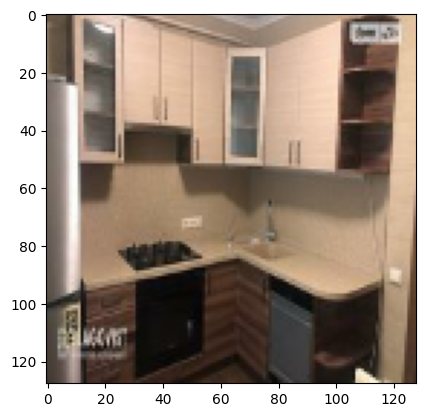

In [ ]:
plt.imshow(batch[10])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow.keras import layers

class ConvLayer(layers.Layer):
    def __init__(self, filters=256, kernel_size=(3, 3), padding='same', alpha=0.2, pool_size=(2, 2), pool=True, **kwargs):
        super(ConvLayer, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding=padding)
        self.leaky_relu = layers.LeakyReLU(alpha=alpha)
        self.batch_norm = layers.BatchNormalization()
        self.max_pool = layers.MaxPool2D(pool_size)
        self.pool = pool

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.leaky_relu(x)
        x = self.batch_norm(x)
        if self.pool:
          x = self.max_pool(x)
        return x

class CustomConvTransposeLayer(layers.Layer):
    def __init__(self, filters=16, kernel_size=3, strides=2, padding='same', alpha=0.2, **kwargs):
        super(CustomConvTransposeLayer, self).__init__(**kwargs)
        self.conv_transpose = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
        self.batch_norm = layers.BatchNormalization()
        self.leaky_relu = layers.LeakyReLU(alpha=alpha)

    def call(self, inputs):
        x = self.conv_transpose(inputs)
        x = self.batch_norm(x)
        return self.leaky_relu(x)


class ConvAutoencoderN(tf.keras.Model):
    def __init__(self):
        super(ConvAutoencoderN, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            ConvLayer(filters=256),
            ConvLayer(filters=128),
            ConvLayer(filters=64),
            ConvLayer(filters=64),
            ConvLayer(filters=64, pool=False)])
            #layers.MaxPool2D((2, 2)),])

        # Decoder
        self.decoder = tf.keras.Sequential([
            CustomConvTransposeLayer(filters=64, strides=1),
            CustomConvTransposeLayer(filters=64, strides=2),
            CustomConvTransposeLayer(filters=64, strides=2),
            CustomConvTransposeLayer(filters=128, strides=2),
            CustomConvTransposeLayer(filters=256, strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = tf.reduce_sum(tf.keras.losses.MSE(data, self.call(data)))

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {
            'loss': loss
        }
    def test_step(self, data):
        loss = tf.reduce_sum(tf.keras.losses.MSE(data, self.call(data)))
        return {
            'loss': loss
        }


In [ ]:
model = ConvAutoencoderN()
  #model.build((None, 256, 256, 6))
model.compile(optimizer=tf.keras.optimizers.Adam())
_ = model(batch[0][None])
model.load_weights('/content/mod_encod_2_0.h5')

In [ ]:
model.save_weights('mod_v_1_0.h5')

In [ ]:
model.summary()

Model: "conv_autoencoder_n_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 8, 8, 64)          452160    
                                                                 
 sequential_5 (Sequential)   (1, 128, 128, 3)          489027    
                                                                 
Total params: 941,187
Trainable params: 938,883
Non-trainable params: 2,304
_________________________________________________________________


In [ ]:
checkpoint_path = "training2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 64

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    #verbose=1,
    save_weights_only=True,
    save_freq=5*batch_size)

In [ ]:
model.fit(train_ds, validation_data=test_ds, callbacks=[cp_callback], epochs=40)

Epoch 1/40
1203/1203 [==============================] - 254s 201ms/step - loss: 3952.3079 - val_loss: 3766.7454
Epoch 2/40
1203/1203 [==============================] - 233s 194ms/step - loss: 3796.5442 - val_loss: 3736.9658
Epoch 3/40
1203/1203 [==============================] - 239s 199ms/step - loss: 3757.4793 - val_loss: 3681.0271
Epoch 4/40
1203/1203 [==============================] - 233s 194ms/step - loss: 3713.0076 - val_loss: 3666.6414
Epoch 5/40
1203/1203 [==============================] - 233s 194ms/step - loss: 3665.4623 - val_loss: 3618.7485
Epoch 6/40
1203/1203 [==============================] - 233s 193ms/step - loss: 3625.2950 - val_loss: 3567.1318
Epoch 7/40
1203/1203 [==============================] - 233s 194ms/step - loss: 3587.8933 - val_loss: 3511.7053
Epoch 8/40
  88/1203 [=>............................] - ETA: 3:21 - loss: 3533.9184

KeyboardInterrupt: ignored

In [ ]:
model.fit(train_ds, validation_data=test_ds, callbacks=[cp_callback], epochs=40)

Epoch 1/40
1204/1204 [==============================] - 256s 203ms/step - loss: 11679.2385 - val_loss: 3076.7539
Epoch 2/40
1204/1204 [==============================] - 236s 196ms/step - loss: 7252.5172 - val_loss: 2602.9585
Epoch 3/40
1204/1204 [==============================] - 236s 196ms/step - loss: 6444.8850 - val_loss: 2488.3062
Epoch 4/40
1204/1204 [==============================] - 236s 196ms/step - loss: 5923.7784 - val_loss: 2243.1270
Epoch 5/40
1204/1204 [==============================] - 236s 196ms/step - loss: 5517.1485 - val_loss: 2565.8784
Epoch 6/40
1204/1204 [==============================] - 236s 196ms/step - loss: 5287.6498 - val_loss: 2015.2375
Epoch 7/40
1204/1204 [==============================] - 236s 196ms/step - loss: 5009.2614 - val_loss: 1972.8340
Epoch 8/40
1204/1204 [==============================] - 236s 196ms/step - loss: 4826.4407 - val_loss: 1860.4507
Epoch 9/40
1204/1204 [==============================] - 235s 196ms/step - loss: 4671.1564 - val_loss: 1

KeyboardInterrupt: ignored

In [ ]:
model.fit(train_ds, validation_data=test_ds, callbacks=[cp_callback], epochs=40)

Epoch 1/40
1244/1244 [==============================] - 77s 58ms/step - loss: 9769.5004 - val_loss: 6158.8877
Epoch 2/40
1244/1244 [==============================] - 73s 59ms/step - loss: 5403.6890 - val_loss: 5309.6113
Epoch 3/40
1244/1244 [==============================] - 73s 58ms/step - loss: 4680.1255 - val_loss: 4472.3018
Epoch 4/40
1244/1244 [==============================] - 73s 58ms/step - loss: 4265.4198 - val_loss: 3984.3438
Epoch 5/40
1244/1244 [==============================] - 73s 58ms/step - loss: 4013.3950 - val_loss: 3761.5623
Epoch 6/40
1244/1244 [==============================] - 73s 58ms/step - loss: 3807.3723 - val_loss: 3550.0134
Epoch 7/40
1244/1244 [==============================] - 73s 58ms/step - loss: 3632.0122 - val_loss: 3421.4043
Epoch 8/40
1244/1244 [==============================] - 73s 59ms/step - loss: 3497.6462 - val_loss: 3302.5833
Epoch 9/40
1244/1244 [==============================] - 73s 58ms/step - loss: 3374.5609 - val_loss: 3283.1748
Epoch 10/4

KeyboardInterrupt: ignored

In [ ]:
model.save_weights('mod1.h5')

In [ ]:
model.fit(train_ds, validation_data=test_ds, callbacks=[cp_callback], epochs=40)

Epoch 1/40
1244/1244 [==============================] - 76s 58ms/step - loss: 10467.0446 - val_loss: 7480.3228
Epoch 2/40
1244/1244 [==============================] - 72s 58ms/step - loss: 6266.8403 - val_loss: 5630.0752
Epoch 3/40
1244/1244 [==============================] - 73s 58ms/step - loss: 5426.3423 - val_loss: 5399.3594
Epoch 4/40
1244/1244 [==============================] - 73s 58ms/step - loss: 5034.0634 - val_loss: 5179.9697
Epoch 5/40
1244/1244 [==============================] - 73s 58ms/step - loss: 4753.2095 - val_loss: 4535.5410
Epoch 6/40
1244/1244 [==============================] - 73s 58ms/step - loss: 4550.2649 - val_loss: 4311.4165
Epoch 7/40
1244/1244 [==============================] - 73s 58ms/step - loss: 4384.4904 - val_loss: 4431.1191
Epoch 8/40
1244/1244 [==============================] - 72s 58ms/step - loss: 4246.7937 - val_loss: 4094.0193
Epoch 9/40
1244/1244 [==============================] - 72s 58ms/step - loss: 4136.3753 - val_loss: 3938.4272
Epoch 10/

KeyboardInterrupt: ignored

In [ ]:
batch[0]

In [ ]:
model.save_weights('mod_encod_2_0.h5')

In [ ]:
res = model(batch[12][None])

In [ ]:
batch[12][None].shape

TensorShape([1, 128, 128, 3])

In [ ]:
plt.imshow(batch[12])

In [ ]:
plt.imshow(res[0])

In [ ]:
model.save_weights('model_v_1_0.h5')